In [1]:
from environments import ZeroDCleanupEnv
from agents import CentralizedQAgent
import numpy as np
from collections import defaultdict
import torch
import sys
from tqdm import tqdm

2023-11-21 15:52:46,591	WARNING deprecation.py:50 -- DeprecationWarning: `DirectStepOptimizer` has been deprecated. This will raise an error in the future!


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
np.set_printoptions(threshold=sys.maxsize)

cpu


In [3]:
num_agents = 10
agent_ids = [str(i) for i in range(num_agents)]
reward_multiplier = 10

In [4]:
pp = False
verbose = False

In [5]:
num_episodes = 200
verbose_episode = num_episodes - 1
max_steps_per_episode = 1000
state_dim = 4
action_dim = 2

In [6]:
thresholdDepletion = 0.4
thresholdRestoration = 0.0
wasteSpawnProbability = 0.5
appleRespawnProbability = 0.05
dirt_multiplier = 10

area = 150

In [7]:
lr = 0.01
gamma = 0.99
epsilon = 0.5
epsilon_decay = 0.9999
epsilon_min = 0.05
batch_size = 128

In [8]:
env = ZeroDCleanupEnv(agent_ids, 
                      num_agents=num_agents, 
                      area=area, 
                      thresholdDepletion=thresholdDepletion,
                      thresholdRestoration=thresholdRestoration,
                      wasteSpawnProbability=wasteSpawnProbability,
                      appleRespawnProbability=appleRespawnProbability,
                      dirt_multiplier=dirt_multiplier)

agentCoordinator = CentralizedQAgent(device=device,
                                     num_agents=num_agents,
                                     action_size=action_dim,
                                     state_dim=state_dim,
                                     lr=lr,
                                     gamma=gamma,
                                     epsilon=epsilon,
                                     epsilon_decay=epsilon_decay,
                                     epsilon_min=epsilon_min,
                                     batch_size=batch_size,
                                     q_layers=[
                                         (state_dim, 128),
                                         (128, 64),
                                         (64, 64),
                                         (64, 32),
                                         (32, action_dim * num_agents)
                                     ],
                                     verbose=False)

In [9]:
ending_ep_rewards = []
weight_graph = defaultdict(list)

In [10]:
import uuid
import os

if not os.path.exists("results"):
    os.mkdir("results")

test_id = uuid.uuid4()
os.mkdir("results/q_simple_" + str(test_id))
f = open("results/q_simple_" + str(test_id) + "/logs.txt", "x")

In [11]:
for episode in range(num_episodes):
    print(f"========= Episode {episode} =========")
    f.write(f"========= Episode {episode} =========\n")

    states, info = env.reset()
    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)
        agentCoordinator.step(state, actions_list, reward, next_state)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    ending_reward = info["total_apple_consumed"]

    print(f"ending reward: {ending_reward}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Episode {episode} =========")
    
    f.write(f"ending reward: {ending_reward}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Episode {episode} =========\n")

    ending_ep_rewards.append(ending_reward)

    if ending_reward > 5000 and ending_ep_rewards[-2] > 5000 and agentCoordinator.epsilon < 0.1:
        break

    

torch.save(agentCoordinator.q_network.state_dict(), "results/q_simple_" + str(test_id) + "/q_network.pt")

        

========= Episode 0 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|█████████▉| 999/1000 [00:01<00:00, 626.64it/s] 


ending reward: 2418
========= End of Episode 0 =========
========= Episode 1 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 407.15it/s]


ending reward: 2642
========= End of Episode 1 =========
========= Episode 2 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 525.92it/s]


ending reward: 2665
========= End of Episode 2 =========
========= Episode 3 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:03<00:00, 314.19it/s]


ending reward: 2721
========= End of Episode 3 =========
========= Episode 4 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 485.42it/s]


ending reward: 2653
========= End of Episode 4 =========
========= Episode 5 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 562.37it/s]


ending reward: 2606
========= End of Episode 5 =========
========= Episode 6 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 509.88it/s]


ending reward: 2709
========= End of Episode 6 =========
========= Episode 7 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 492.21it/s]


ending reward: 2649
========= End of Episode 7 =========
========= Episode 8 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 530.59it/s]


ending reward: 2678
========= End of Episode 8 =========
========= Episode 9 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 497.52it/s]


ending reward: 2698
========= End of Episode 9 =========
========= Episode 10 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 597.59it/s]


ending reward: 2711
========= End of Episode 10 =========
========= Episode 11 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 700.10it/s]


ending reward: 2673
========= End of Episode 11 =========
========= Episode 12 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 658.68it/s]


ending reward: 2547
========= End of Episode 12 =========
========= Episode 13 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 543.84it/s]


ending reward: 2521
========= End of Episode 13 =========
========= Episode 14 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 430.84it/s]


ending reward: 2556
========= End of Episode 14 =========
========= Episode 15 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 435.82it/s]


ending reward: 2384
========= End of Episode 15 =========
========= Episode 16 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 493.44it/s]


ending reward: 2302
========= End of Episode 16 =========
========= Episode 17 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 554.83it/s]


ending reward: 2223
========= End of Episode 17 =========
========= Episode 18 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 419.63it/s]


ending reward: 2067
========= End of Episode 18 =========
========= Episode 19 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 651.75it/s]


ending reward: 1731
========= End of Episode 19 =========
========= Episode 20 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 551.36it/s]


ending reward: 1791
========= End of Episode 20 =========
========= Episode 21 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 571.61it/s]


ending reward: 1823
========= End of Episode 21 =========
========= Episode 22 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 608.07it/s]


ending reward: 1627
========= End of Episode 22 =========
========= Episode 23 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 555.28it/s]


ending reward: 1297
========= End of Episode 23 =========
========= Episode 24 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 621.68it/s]


ending reward: 968
========= End of Episode 24 =========
========= Episode 25 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 652.17it/s]


ending reward: 580
========= End of Episode 25 =========
========= Episode 26 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 638.03it/s]


ending reward: 450
========= End of Episode 26 =========
========= Episode 27 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 525.77it/s]


ending reward: 346
========= End of Episode 27 =========
========= Episode 28 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 604.10it/s]


ending reward: 305
========= End of Episode 28 =========
========= Episode 29 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 592.67it/s]


ending reward: 274
========= End of Episode 29 =========
========= Episode 30 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 620.49it/s]


ending reward: 212
========= End of Episode 30 =========
========= Episode 31 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 634.50it/s]


ending reward: 268
========= End of Episode 31 =========
========= Episode 32 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 642.76it/s]


ending reward: 260
========= End of Episode 32 =========
========= Episode 33 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 654.24it/s]


ending reward: 248
========= End of Episode 33 =========
========= Episode 34 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 654.43it/s]


ending reward: 205
========= End of Episode 34 =========
========= Episode 35 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 649.09it/s]


ending reward: 208
========= End of Episode 35 =========
========= Episode 36 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 672.57it/s]


ending reward: 135
========= End of Episode 36 =========
========= Episode 37 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 651.93it/s]


ending reward: 144
========= End of Episode 37 =========
========= Episode 38 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 676.23it/s]


ending reward: 167
========= End of Episode 38 =========
========= Episode 39 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 599.23it/s]


ending reward: 206
========= End of Episode 39 =========
========= Episode 40 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 635.26it/s]


ending reward: 135
========= End of Episode 40 =========
========= Episode 41 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 450.28it/s]


ending reward: 160
========= End of Episode 41 =========
========= Episode 42 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:03<00:00, 332.58it/s]


ending reward: 181
========= End of Episode 42 =========
========= Episode 43 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 639.59it/s]


ending reward: 235
========= End of Episode 43 =========
========= Episode 44 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 619.62it/s]


ending reward: 431
========= End of Episode 44 =========
========= Episode 45 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 637.99it/s]


ending reward: 264
========= End of Episode 45 =========
========= Episode 46 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 648.61it/s]


ending reward: 231
========= End of Episode 46 =========
========= Episode 47 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 670.74it/s]


ending reward: 113
========= End of Episode 47 =========
========= Episode 48 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 650.88it/s]


ending reward: 146
========= End of Episode 48 =========
========= Episode 49 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 654.89it/s]


ending reward: 191
========= End of Episode 49 =========
========= Episode 50 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 638.24it/s]


ending reward: 308
========= End of Episode 50 =========
========= Episode 51 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 673.96it/s]


ending reward: 383
========= End of Episode 51 =========
========= Episode 52 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 651.26it/s]


ending reward: 309
========= End of Episode 52 =========
========= Episode 53 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 603.99it/s]


ending reward: 252
========= End of Episode 53 =========
========= Episode 54 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 658.12it/s]


ending reward: 401
========= End of Episode 54 =========
========= Episode 55 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 680.79it/s]


ending reward: 355
========= End of Episode 55 =========
========= Episode 56 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 645.25it/s]


ending reward: 227
========= End of Episode 56 =========
========= Episode 57 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 666.97it/s]


ending reward: 207
========= End of Episode 57 =========
========= Episode 58 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 662.22it/s]


ending reward: 124
========= End of Episode 58 =========
========= Episode 59 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 678.22it/s]


ending reward: 86
========= End of Episode 59 =========
========= Episode 60 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 649.32it/s]


ending reward: 83
========= End of Episode 60 =========
========= Episode 61 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:15<00:00, 63.15it/s] 


ending reward: 349
========= End of Episode 61 =========
========= Episode 62 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 416.78it/s]


ending reward: 786
========= End of Episode 62 =========
========= Episode 63 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 626.11it/s]


ending reward: 677
========= End of Episode 63 =========
========= Episode 64 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 604.75it/s]


ending reward: 330
========= End of Episode 64 =========
========= Episode 65 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 566.26it/s]


ending reward: 295
========= End of Episode 65 =========
========= Episode 66 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 568.14it/s]


ending reward: 250
========= End of Episode 66 =========
========= Episode 67 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 560.88it/s]


ending reward: 112
========= End of Episode 67 =========
========= Episode 68 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 646.32it/s]


ending reward: 220
========= End of Episode 68 =========
========= Episode 69 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 592.16it/s]


ending reward: 165
========= End of Episode 69 =========
========= Episode 70 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 602.72it/s]


ending reward: 104
========= End of Episode 70 =========
========= Episode 71 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 525.02it/s]


ending reward: 639
========= End of Episode 71 =========
========= Episode 72 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 666.34it/s]


ending reward: 932
========= End of Episode 72 =========
========= Episode 73 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 627.45it/s]


ending reward: 946
========= End of Episode 73 =========
========= Episode 74 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 661.20it/s]


ending reward: 548
========= End of Episode 74 =========
========= Episode 75 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 623.35it/s]


ending reward: 388
========= End of Episode 75 =========
========= Episode 76 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 662.47it/s]


ending reward: 192
========= End of Episode 76 =========
========= Episode 77 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 604.50it/s]


ending reward: 154
========= End of Episode 77 =========
========= Episode 78 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 646.52it/s]


ending reward: 611
========= End of Episode 78 =========
========= Episode 79 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 647.66it/s]


ending reward: 1026
========= End of Episode 79 =========
========= Episode 80 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 675.68it/s]


ending reward: 1075
========= End of Episode 80 =========
========= Episode 81 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 653.50it/s]


ending reward: 795
========= End of Episode 81 =========
========= Episode 82 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 661.08it/s]


ending reward: 481
========= End of Episode 82 =========
========= Episode 83 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 645.42it/s]


ending reward: 480
========= End of Episode 83 =========
========= Episode 84 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 666.09it/s]


ending reward: 770
========= End of Episode 84 =========
========= Episode 85 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 634.10it/s]


ending reward: 424
========= End of Episode 85 =========
========= Episode 86 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 662.58it/s]


ending reward: 210
========= End of Episode 86 =========
========= Episode 87 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 655.11it/s]


ending reward: 149
========= End of Episode 87 =========
========= Episode 88 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 666.66it/s]


ending reward: 95
========= End of Episode 88 =========
========= Episode 89 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 576.31it/s]


ending reward: 418
========= End of Episode 89 =========
========= Episode 90 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 638.38it/s]


ending reward: 349
========= End of Episode 90 =========
========= Episode 91 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 658.27it/s]


ending reward: 425
========= End of Episode 91 =========
========= Episode 92 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 536.03it/s]


ending reward: 784
========= End of Episode 92 =========
========= Episode 93 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 636.40it/s]


ending reward: 797
========= End of Episode 93 =========
========= Episode 94 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 581.43it/s]


ending reward: 1147
========= End of Episode 94 =========
========= Episode 95 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 641.06it/s]


ending reward: 1001
========= End of Episode 95 =========
========= Episode 96 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 648.89it/s]


ending reward: 546
========= End of Episode 96 =========
========= Episode 97 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 641.78it/s]


ending reward: 460
========= End of Episode 97 =========
========= Episode 98 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 638.80it/s]


ending reward: 278
========= End of Episode 98 =========
========= Episode 99 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 650.13it/s]


ending reward: 128
========= End of Episode 99 =========
========= Episode 100 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 561.24it/s]


ending reward: 207
========= End of Episode 100 =========
========= Episode 101 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 642.37it/s]


ending reward: 157
========= End of Episode 101 =========
========= Episode 102 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 645.28it/s]


ending reward: 785
========= End of Episode 102 =========
========= Episode 103 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 665.57it/s]


ending reward: 954
========= End of Episode 103 =========
========= Episode 104 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 639.86it/s]


ending reward: 811
========= End of Episode 104 =========
========= Episode 105 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 613.60it/s]


ending reward: 911
========= End of Episode 105 =========
========= Episode 106 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 645.36it/s]


ending reward: 928
========= End of Episode 106 =========
========= Episode 107 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 671.29it/s]


ending reward: 1201
========= End of Episode 107 =========
========= Episode 108 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 638.58it/s]


ending reward: 1544
========= End of Episode 108 =========
========= Episode 109 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 668.06it/s]


ending reward: 1180
========= End of Episode 109 =========
========= Episode 110 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 652.23it/s]


ending reward: 561
========= End of Episode 110 =========
========= Episode 111 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 663.90it/s]


ending reward: 455
========= End of Episode 111 =========
========= Episode 112 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 619.26it/s]


ending reward: 267
========= End of Episode 112 =========
========= Episode 113 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 667.42it/s]


ending reward: 457
========= End of Episode 113 =========
========= Episode 114 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 460.40it/s]


ending reward: 2227
========= End of Episode 114 =========
========= Episode 115 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 640.60it/s]


ending reward: 2224
========= End of Episode 115 =========
========= Episode 116 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 649.99it/s]


ending reward: 2251
========= End of Episode 116 =========
========= Episode 117 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 673.91it/s]


ending reward: 2218
========= End of Episode 117 =========
========= Episode 118 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:04<00:00, 239.57it/s]


ending reward: 2256
========= End of Episode 118 =========
========= Episode 119 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 659.65it/s]


ending reward: 2079
========= End of Episode 119 =========
========= Episode 120 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 681.79it/s]


ending reward: 2066
========= End of Episode 120 =========
========= Episode 121 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 664.67it/s]


ending reward: 1878
========= End of Episode 121 =========
========= Episode 122 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 619.55it/s]


ending reward: 1764
========= End of Episode 122 =========
========= Episode 123 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [01:46<00:00,  9.40it/s] 


ending reward: 1033
========= End of Episode 123 =========
========= Episode 124 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 672.36it/s]


ending reward: 913
========= End of Episode 124 =========
========= Episode 125 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 635.14it/s]


ending reward: 716
========= End of Episode 125 =========
========= Episode 126 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 570.77it/s]


ending reward: 351
========= End of Episode 126 =========
========= Episode 127 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 655.58it/s]


ending reward: 169
========= End of Episode 127 =========
========= Episode 128 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 660.47it/s]


ending reward: 386
========= End of Episode 128 =========
========= Episode 129 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 647.53it/s]


ending reward: 317
========= End of Episode 129 =========
========= Episode 130 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [01:55<00:00,  8.62it/s] 


ending reward: 728
========= End of Episode 130 =========
========= Episode 131 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 584.55it/s]


ending reward: 786
========= End of Episode 131 =========
========= Episode 132 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 663.31it/s]


ending reward: 786
========= End of Episode 132 =========
========= Episode 133 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 607.38it/s]


ending reward: 375
========= End of Episode 133 =========
========= Episode 134 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 650.06it/s]


ending reward: 494
========= End of Episode 134 =========
========= Episode 135 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 659.28it/s]


ending reward: 526
========= End of Episode 135 =========
========= Episode 136 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 602.07it/s]


ending reward: 436
========= End of Episode 136 =========
========= Episode 137 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 649.93it/s]


ending reward: 347
========= End of Episode 137 =========
========= Episode 138 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 656.32it/s]


ending reward: 783
========= End of Episode 138 =========
========= Episode 139 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 648.87it/s]


ending reward: 2114
========= End of Episode 139 =========
========= Episode 140 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 611.18it/s]


ending reward: 1951
========= End of Episode 140 =========
========= Episode 141 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 589.02it/s]


ending reward: 1997
========= End of Episode 141 =========
========= Episode 142 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 660.50it/s]


ending reward: 2120
========= End of Episode 142 =========
========= Episode 143 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 654.25it/s]


ending reward: 2050
========= End of Episode 143 =========
========= Episode 144 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 661.75it/s]


ending reward: 1531
========= End of Episode 144 =========
========= Episode 145 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 652.69it/s]


ending reward: 1543
========= End of Episode 145 =========
========= Episode 146 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 663.96it/s]


ending reward: 1290
========= End of Episode 146 =========
========= Episode 147 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 616.26it/s]


ending reward: 829
========= End of Episode 147 =========
========= Episode 148 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 680.50it/s]


ending reward: 652
========= End of Episode 148 =========
========= Episode 149 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 625.59it/s]


ending reward: 550
========= End of Episode 149 =========
========= Episode 150 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:15<00:00, 63.14it/s] 


ending reward: 2285
========= End of Episode 150 =========
========= Episode 151 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 637.57it/s]


ending reward: 2146
========= End of Episode 151 =========
========= Episode 152 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 679.78it/s]


ending reward: 2358
========= End of Episode 152 =========
========= Episode 153 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 664.43it/s]


ending reward: 2268
========= End of Episode 153 =========
========= Episode 154 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 679.39it/s]


ending reward: 2120
========= End of Episode 154 =========
========= Episode 155 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 653.30it/s]


ending reward: 1849
========= End of Episode 155 =========
========= Episode 156 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 678.52it/s]


ending reward: 1893
========= End of Episode 156 =========
========= Episode 157 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 650.29it/s]


ending reward: 1742
========= End of Episode 157 =========
========= Episode 158 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 681.01it/s]


ending reward: 1256
========= End of Episode 158 =========
========= Episode 159 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 655.70it/s]


ending reward: 935
========= End of Episode 159 =========
========= Episode 160 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 621.00it/s]


ending reward: 542
========= End of Episode 160 =========
========= Episode 161 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 633.95it/s]


ending reward: 220
========= End of Episode 161 =========
========= Episode 162 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:04<00:00, 206.19it/s]


ending reward: 613
========= End of Episode 162 =========
========= Episode 163 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 640.93it/s]


ending reward: 555
========= End of Episode 163 =========
========= Episode 164 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 579.02it/s]


ending reward: 428
========= End of Episode 164 =========
========= Episode 165 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 669.14it/s]


ending reward: 486
========= End of Episode 165 =========
========= Episode 166 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 635.46it/s]


ending reward: 737
========= End of Episode 166 =========
========= Episode 167 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:19<00:00, 51.60it/s] 


ending reward: 483
========= End of Episode 167 =========
========= Episode 168 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 606.32it/s]


ending reward: 535
========= End of Episode 168 =========
========= Episode 169 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 643.69it/s]


ending reward: 333
========= End of Episode 169 =========
========= Episode 170 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 657.40it/s]


ending reward: 542
========= End of Episode 170 =========
========= Episode 171 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 651.00it/s]


ending reward: 421
========= End of Episode 171 =========
========= Episode 172 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 622.24it/s]


ending reward: 512
========= End of Episode 172 =========
========= Episode 173 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 663.37it/s]


ending reward: 800
========= End of Episode 173 =========
========= Episode 174 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 517.39it/s]


ending reward: 1019
========= End of Episode 174 =========
========= Episode 175 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 676.66it/s]


ending reward: 517
========= End of Episode 175 =========
========= Episode 176 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 651.25it/s]


ending reward: 733
========= End of Episode 176 =========
========= Episode 177 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 677.84it/s]


ending reward: 1658
========= End of Episode 177 =========
========= Episode 178 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 640.38it/s]


ending reward: 1029
========= End of Episode 178 =========
========= Episode 179 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 359.49it/s]


ending reward: 521
========= End of Episode 179 =========
========= Episode 180 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 643.72it/s]


ending reward: 461
========= End of Episode 180 =========
========= Episode 181 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 670.91it/s]


ending reward: 1271
========= End of Episode 181 =========
========= Episode 182 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 658.32it/s]


ending reward: 1231
========= End of Episode 182 =========
========= Episode 183 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 677.34it/s]


ending reward: 1361
========= End of Episode 183 =========
========= Episode 184 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 659.14it/s]


ending reward: 1467
========= End of Episode 184 =========
========= Episode 185 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 655.97it/s]


ending reward: 1183
========= End of Episode 185 =========
========= Episode 186 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 656.42it/s]


ending reward: 1190
========= End of Episode 186 =========
========= Episode 187 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [04:10<00:00,  3.99it/s] 


ending reward: 494
========= End of Episode 187 =========
========= Episode 188 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 462.93it/s]


ending reward: 60
========= End of Episode 188 =========
========= Episode 189 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 593.76it/s]


ending reward: 24
========= End of Episode 189 =========
========= Episode 190 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 417.13it/s]


ending reward: 38
========= End of Episode 190 =========
========= Episode 191 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 530.72it/s]


ending reward: 34
========= End of Episode 191 =========
========= Episode 192 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 616.26it/s]


ending reward: 48
========= End of Episode 192 =========
========= Episode 193 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 565.94it/s]


ending reward: 61
========= End of Episode 193 =========
========= Episode 194 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 634.09it/s]


ending reward: 22
========= End of Episode 194 =========
========= Episode 195 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 509.25it/s]


ending reward: 66
========= End of Episode 195 =========
========= Episode 196 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 513.87it/s]


ending reward: 32
========= End of Episode 196 =========
========= Episode 197 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 616.13it/s]


ending reward: 55
========= End of Episode 197 =========
========= Episode 198 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:02<00:00, 488.99it/s]


ending reward: 42
========= End of Episode 198 =========
========= Episode 199 =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:01<00:00, 601.93it/s]

ending reward: 1536
========= End of Episode 199 =========


In [13]:
test_stats = []
num_test_episodes = 15
print("========= Testing =========")
f.write("========= Testing =========\n")

for episode in range(num_test_episodes):
    test_stats.append({
        "num_apples": [],
        "num_dirt": [],
        "pickers": [],
        "cleaners": [],
        "total_reward": 0,
    })

    states, info = env.reset()
    test_stats[-1]["num_apples"].append(info["apple"])
    test_stats[-1]["num_dirt"].append(info["dirt"])
    test_stats[-1]["pickers"].append(info["picker"])
    test_stats[-1]["cleaners"].append(info["cleaner"])

    #states = np.concatenate(list(states.values()), axis=0)
    state = states[agent_ids[0]]
    num_apples, num_dirt, num_picker, num_cleaner = state
    #state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
    state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])

    print(f"info: {info}")
    f.write(f"info: {info}\n")

    for step in tqdm(range(max_steps_per_episode)):
        actions_list = agentCoordinator.act(state)[0]
        actions = {agent_id: actions_list[i] for i, agent_id in enumerate(agent_ids)}
        next_states, rewards, dones, _, info = env.step(actions)
        test_stats[-1]["num_apples"].append(info["apple"])
        test_stats[-1]["num_dirt"].append(info["dirt"])
        test_stats[-1]["pickers"].append(info["picker"])
        test_stats[-1]["cleaners"].append(info["cleaner"])
        #next_states = np.concatenate(list(next_states.values()), axis=0)
        next_state = next_states[agent_ids[0]]
        num_apples, num_dirt, num_picker, num_cleaner = next_state
        #next_state = np.array([num_apples / num_dirt, num_picker, num_cleaner])
        next_state = np.array([num_apples / (num_picker + 1e-7), num_dirt / (num_cleaner + 1e-7), num_apples, num_dirt])
        reward = sum(rewards.values())
        #reward_graph.append(reward)

        if episode > verbose_episode:
            print(f"========= Step {step} =========")
            print(f"info: {info}")
            f.write(f"========= Step {step} =========\n")
            f.write(f"info: {info}\n")

        state = next_state

        if dones["__all__"]:
            break 

    print(f"ending info: {info}")
    #print(f"reward graph: {reward_graph}")
    print(f"========= End of Test =========")

    f.write(f"ending info: {info}\n")
    #f.write(f"reward graph: {reward_graph}\n")
    f.write(f"========= End of Test =========\n")

    test_reward = info["total_apple_consumed"]

    test_stats[-1]["total_reward"] = test_reward

    print(test_reward)

========= Testing =========
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 4561.97it/s]


ending info: {'total_apple_consumed': 2563, 'step_apple_consumed': 4, 'apple': 65, 'dirt': 23, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2563
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5453.47it/s]


ending info: {'total_apple_consumed': 2560, 'step_apple_consumed': 3, 'apple': 61, 'dirt': 19, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2560
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5884.46it/s]


ending info: {'total_apple_consumed': 2710, 'step_apple_consumed': 4, 'apple': 51, 'dirt': 20, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2710
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5724.76it/s]


ending info: {'total_apple_consumed': 2526, 'step_apple_consumed': 1, 'apple': 52, 'dirt': 26, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2526
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5838.14it/s]


ending info: {'total_apple_consumed': 2605, 'step_apple_consumed': 2, 'apple': 63, 'dirt': 24, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2605
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5288.23it/s]


ending info: {'total_apple_consumed': 2528, 'step_apple_consumed': 1, 'apple': 56, 'dirt': 30, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2528
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 4588.55it/s]


ending info: {'total_apple_consumed': 2717, 'step_apple_consumed': 1, 'apple': 72, 'dirt': 27, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2717
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5594.88it/s]


ending info: {'total_apple_consumed': 2494, 'step_apple_consumed': 3, 'apple': 57, 'dirt': 27, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2494
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5813.14it/s]


ending info: {'total_apple_consumed': 2716, 'step_apple_consumed': 7, 'apple': 52, 'dirt': 28, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2716
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5201.87it/s]


ending info: {'total_apple_consumed': 2535, 'step_apple_consumed': 2, 'apple': 58, 'dirt': 24, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2535
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5312.02it/s]


ending info: {'total_apple_consumed': 2528, 'step_apple_consumed': 3, 'apple': 71, 'dirt': 22, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2528
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5202.33it/s]


ending info: {'total_apple_consumed': 2683, 'step_apple_consumed': 4, 'apple': 62, 'dirt': 19, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2683
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 4317.01it/s]


ending info: {'total_apple_consumed': 2579, 'step_apple_consumed': 2, 'apple': 55, 'dirt': 27, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2579
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5323.43it/s]


ending info: {'total_apple_consumed': 2646, 'step_apple_consumed': 4, 'apple': 59, 'dirt': 23, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2646
info: {'total_apple_consumed': 0, 'step_apple_consumed': 0, 'apple': 0, 'dirt': 78, 'picker': 0, 'cleaner': 0}


100%|█████████▉| 999/1000 [00:00<00:00, 5396.76it/s]

ending info: {'total_apple_consumed': 2548, 'step_apple_consumed': 1, 'apple': 57, 'dirt': 30, 'picker': 7, 'cleaner': 3}
========= End of Test =========
2548


In [14]:
import matplotlib.pyplot as plt

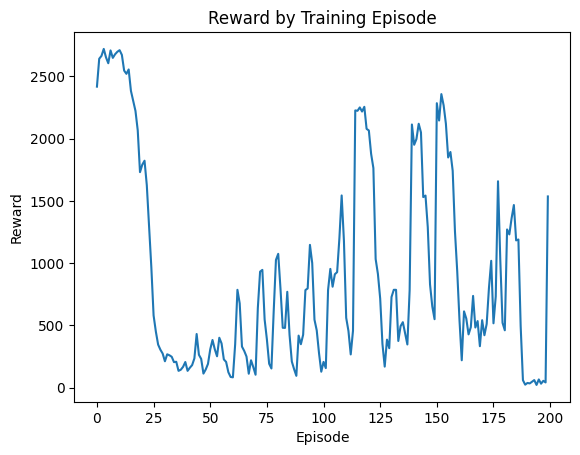

In [15]:
plt.title("Reward by Training Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot(ending_ep_rewards)
plt.show()

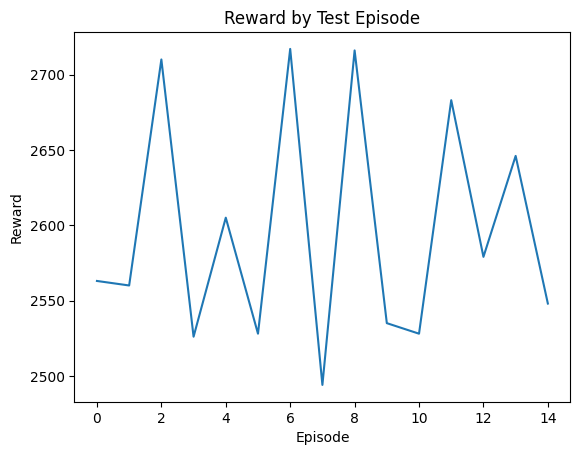

In [16]:
plt.figure()
plt.title("Reward by Test Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.plot([stat['total_reward'] for stat in test_stats])
plt.show()

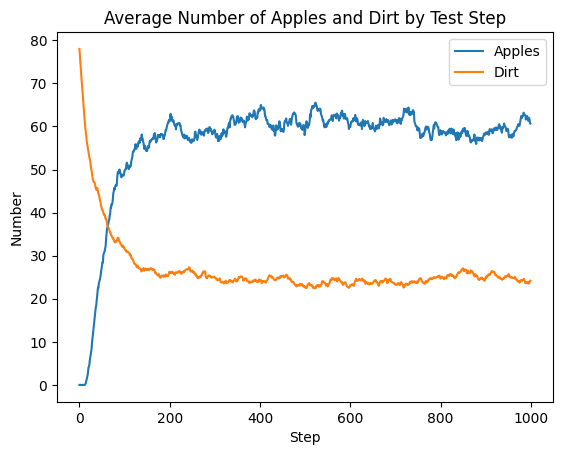

In [17]:
plt.figure()
plt.title("Average Number of Apples and Dirt by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_apples = []
avg_num_dirt = []
for i in range(max_steps_per_episode):
    avg_num_apples.append(np.mean([stat['num_apples'][i] for stat in test_stats]))
    avg_num_dirt.append(np.mean([stat['num_dirt'][i] for stat in test_stats]))
plt.plot(avg_num_apples, label="Apples")
plt.plot(avg_num_dirt, label="Dirt")
plt.legend()
plt.show()

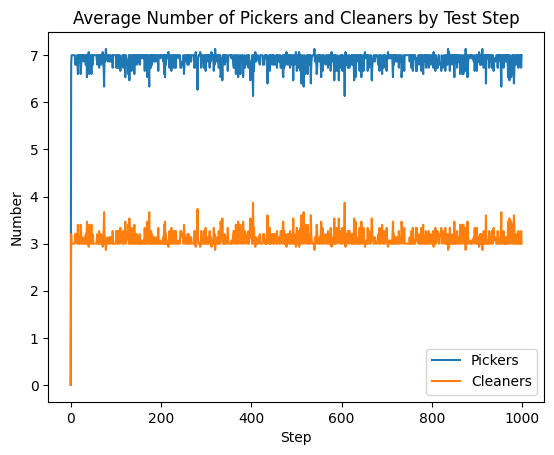

In [18]:
plt.figure()
plt.title("Average Number of Pickers and Cleaners by Test Step")
plt.xlabel("Step")
plt.ylabel("Number")
avg_num_pickers = []
avg_num_cleaners = []
for i in range(max_steps_per_episode):
    avg_num_pickers.append(np.mean([stat['pickers'][i] for stat in test_stats]))
    avg_num_cleaners.append(np.mean([stat['cleaners'][i] for stat in test_stats]))
plt.plot(avg_num_pickers, label="Pickers")
plt.plot(avg_num_cleaners, label="Cleaners")
plt.legend()
plt.show()

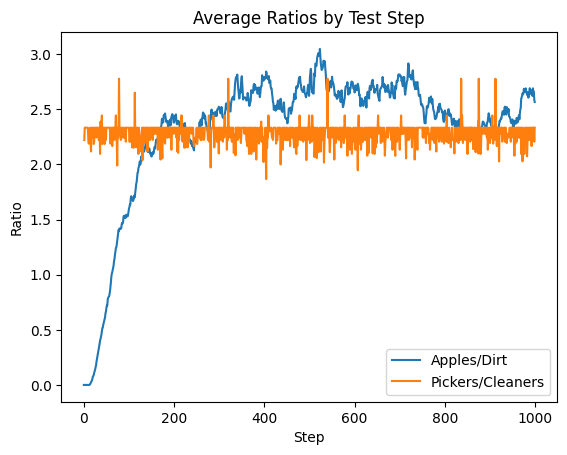

In [19]:
plt.figure()
plt.title("Average Ratios by Test Step")
plt.xlabel("Step")
plt.ylabel("Ratio")
avg_apple_dirt_ratios = []
apple_dirt_steps = []
avg_picker_cleaner_ratios = []
picker_cleaner_steps = []
for i in range(max_steps_per_episode):
    #avg_apple_dirt_ratios.append(np.mean([stat['num_apples'][i] / (stat['num_dirt'][i] + 1e-8) for stat in test_stats]))
    #avg_picker_cleaner_ratios.append(np.mean([stat['pickers'][i] / (stat['cleaners'][i]) for stat in test_stats if stat['cleaners'][i] > 0]))
    apple_dirt = []
    picker_cleaner = []
    for stat in test_stats:
        if stat['num_dirt'][i] > 0:
            apple_dirt.append(stat['num_apples'][i] / stat['num_dirt'][i])
        if stat['cleaners'][i] > 0:
            picker_cleaner.append(stat['pickers'][i] / stat['cleaners'][i])
    if len(apple_dirt) > 0:
        avg_apple_dirt_ratios.append(np.mean(apple_dirt))
        apple_dirt_steps.append(i)
    if len(picker_cleaner) > 0:
        avg_picker_cleaner_ratios.append(np.mean(picker_cleaner))
        picker_cleaner_steps.append(i)

plt.plot(apple_dirt_steps, avg_apple_dirt_ratios, label="Apples/Dirt")
plt.plot(picker_cleaner_steps, avg_picker_cleaner_ratios, label="Pickers/Cleaners")
plt.legend()
plt.show()